In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Let's us generate an **undirected weighted** Graph with **11** nodes 

In [2]:
import networkx as nx
import pylab as plt
import pandas as pd
import argparse
import random
import numpy as np
import matplotlib.pyplot as plt

Let's define the Energy required to transmit the data and the energy required to receive the data

\begin{equation}
  E_{Tx} = 
   k \times E_{elec} + k \times d^2 \times E_{fs} \qquad if \qquad  d< d_0\\
\end{equation}

\begin{equation}
  E_{Tx} =
   k \times E_{elec} + k \times d^4 \times E_{mp} \qquad if \qquad  d> d_0\\
\end{equation}


\begin{equation}
  E_{Rx} = k \times E_{elec} 
\end{equation}


In [3]:
k = 4000  # k represent the number of bytes actually it is 500 bytes
Eelec = 50*10**(-9)  #  Eelec represents the electronic energy consumption (50nJ/bit)
Efs = 10*10**(-12)  # Eamp represents the Transmit amplifier (10pJ/bit/m^2)
Emp = 0.0013*10**(-12)  # Eamp represents the Transmit amplifier (0.0013pJ/bit/m^4)
d0 = 87

ERex = k*Eelec  # ERex represents the energy required for receiving data



def ETx(d):
    """
    This function computes the transmission energy of nodes
    """
    if d < d0:
        return k*Eelec + k*d**2*Efs
    else:
        return k*Eelec + k*d**4*Emp



### Environment setup

In [16]:
class Env(object):

    '''
  Environment definition

  '''

    def __init__(self, args):
        self.topology_path = args['topology_path']
        self.num_path = args['num_path']
        self.num_request = args['num_request']
        self.Graph =  nx.read_gml(self.topology_path)
        self.request = self.Data_Generator()
        self.statistic = None
        self.reset()

    

    def Data_Generator(self):

        df = pd.DataFrame(columns=['id','source','path'])
        df.loc[0]=[0,'i',['f']]
        random.seed(237)
        active_nodes = list(self.Graph.nodes)[1:] # all the nodes except sink node

        for i in range(self.num_request):
            src = random.choice(active_nodes)
            dst = list(self.Graph.nodes)[0]
            k_paths = self.get_k_paths(src, dst)

            df.loc[i+1]=[i,src,[j for i,j in enumerate(k_paths.path) if i <= k-1]]

        df.drop(index=0,inplace=True)

        return df

  

    def get_k_paths(self, src, dst):
    
        paths = nx.all_simple_paths(self.Graph, source=src, target=dst, cutoff=7) 
        all_paths = list(paths)

        ListeEnergy = [] # This list contains the sum of the transmission energy in all the possible paths 

        for j in range(len(all_paths)): # j will go through all the length of our liste of possible paths

            Energy = []               # Energy will contains all the transmission energy in each segment of a certain path

            for i in range(len(all_paths[j])): # i will go through all the length of one of the possible path
                if i == 0:                   # If the node is the source node, we don't use the ERx
                    self.Graph.nodes[all_paths[j][i]]["Energy"] -= ETx(self.Graph[all_paths[j][i]][all_paths[j][i + 1]]['weight'])                                             # We update the energy of the source node
                    Energy.append(ETx(self.Graph[all_paths[j][i]][all_paths[j][i + 1]]['weight']))                                                                # We append the transmission energy in the liste Energy that we have created 
                elif i!=0 and i!= len(all_paths[j]) - 1:                                                                                            # If the node is a node situated in the transfer path 
                    self.Graph.nodes[all_paths[j][i]]["Energy"] = self.Graph.nodes[all_paths[j][i]]["Energy"] - ETx(self.Graph[all_paths[j][i]][all_paths[j][i + 1]]['weight']) - ERex   # We update the energy of each node situated in the transfer path
                    Energy.append(ETx(self.Graph[all_paths[j][i]][all_paths[j][i + 1]]['weight']) + ERex)                                                               # We append the transmission energy in the liste Energy that we have created 
                else:
                    self.Graph.nodes[all_paths[j][i]]["Energy"]  = self.Graph.nodes[all_paths[j][i]]["Energy"]                                                           # The energy of the destination node remains the same
                  #Energy.append(ETx(G1[liste[j][i - 1]][liste[j][i ]]['weight']))
                Energysum = sum(Energy)                                              # We sum the transmission energy of all the segment of each path 
                ListeEnergy.append(Energysum)    
        z = list(zip(ListeEnergy, all_paths))                                      # We append the transmission energy of each path
        datass = pd.DataFrame(z, columns=['cost_energy','path'])
        datass = datass.sort_values(by='cost_energy')
        return datass                                                   # We print the list containing all the transmission energy
                                                    # We print the length of the list  
  
    def get_state(self, id_request):
        src = self.request.source.iloc[id_request]
        dst = list(self.Graph.nodes)[0]
        active_nodes = list(self.Graph.nodes)[1:] # all the nodes except sink node
        One_hot_encoding = np.zeros(len(active_nodes), dtype=int)

        One_hot_encoding[active_nodes.index(src)] = 1

        Energy = [self.Graph.nodes[node]["Energy"] for node in active_nodes]
        self.state =  np.append(One_hot_encoding, Energy)

        return self.state


    def act(self, action, id_request) :
        path = self.request.path.iloc[id_request][action]

        done = self.is_over(id_request)
        if done:
            self.next_state = self.state
        else:
            self.next_state = self.get_state(id_request + 1)

        if not self.isFeasible(path):
            self.reward = self.get_reward(path, False)

          # for statistic
            self.record_result.loc[id_request,'status'] = 'Rejected'

        else:
            self.update_env(path)
            self.reward = self.get_reward(path, True)

          # for statistic
            self.record_result.loc[id_request,'status'] = 'Accepted'

        # record selected path
        self.record_result.loc[id_request,'source'] = self.request.source.iloc[id_request]
        self.record_result.loc[id_request,'selected_path'] = self.request.path.iloc[id_request][action]
        return self.next_state, self.reward, done
     
      

    def get_reward(self, path, status):
        if not status:
            reward = 0

        else:
            EnergyCons = []
            for i in range(len(path)):
                if i == 0:
                    self.Graph.nodes[path[i]]["Energy"] -= ETx(self.Graph[path[i]][path[i + 1]]['weight'])
                    EnergyCons.append(ETx(self.Graph[path[i]][path[i + 1]]['weight']))
                elif i!=0 and i!= len(path) - 1:
                    self.Graph.nodes[path[i]]["Energy"] = self.Graph.nodes[path[i]]["Energy"] - ETx(self.Graph[path[i]][path[i + 1]]['weight']) - ERex 
                    EnergyCons.append(ETx(self.Graph[path[i]][path[i + 1]]['weight']) + ERex)

                reward =  1/sum(EnergyCons)

        return reward

  
    def is_over(self, id_request):
        if id_request == len(self.request) -1:
            return True
        else:
            return False


    def update_env(self, path):
        for i in range(len(path)):
            if i == 0:
                self.Graph.nodes[path[i]]["Energy"] -= ETx(self.Graph[path[i]][path[i + 1]]['weight'])
            elif i!=0 and i!= len(path) - 1:
                self.Graph.nodes[path[i]]["Energy"] = self.Graph.nodes[path[i]]["Energy"] - ETx(self.Graph[path[i]][path[i + 1]]['weight']) - ERex
    


    def isFeasible(self, path):
        S = path[0]
        D = path[-1]

        for k in range(len(path)):
            if k == 0:
                if self.Graph.nodes[path[k]]["Energy"] < ETx(self.Graph[path[k]][path[k + 1]]['weight']):
                    return False 

            elif  k!= len(path) - 1:
                if self.Graph.nodes[path[k]]["Energy"] < ETx(self.Graph[path[k]][path[k + 1]]['weight']) + ERex:
                    return False 
            else:

                return True #"The value of the iteration is:", count 

    def reset(self):
        self.Graph =  nx.read_gml(self.topology_path)

        self.record_result = pd.DataFrame(columns=['source', 'selected_path', 'status'])


In [17]:
def ParseParams(topology_path):
    parser = argparse.ArgumentParser(description="Input data of the Environment")
    parser.add_argument('--topology_path', default=topology_path,type=str, help='Name of the network topology')
    parser.add_argument('--num_path', default=5, type=int, help='Number of paths')
    parser.add_argument('--num_request', default=3000, type=int, help='Number of requests')
    parser.add_argument('--num_episode', default=15, type=int, help='Number of episodes')

    args, _ = parser.parse_known_args()
    args = vars(args)

    return args



In [18]:
import argparse
from argparse import ArgumentParser

In [19]:
topology_path = "/content/gdrive/MyDrive/Networkx/Graph21.gml"
args = ParseParams(topology_path)

# DQN ALGORITHM



**Packages**


First, let's import needed packages. Firstly, we need
`gym <https://gym.openai.com/docs>`__ for the environment
(Install using `pip install gym`).
We'll also use the following from PyTorch:

-  neural networks (``torch.nn``)
-  optimization (``torch.optim``)
-  automatic differentiation (``torch.autograd``)
-  utilities for vision tasks (``torchvision`` - `a separate
   package <https://github.com/pytorch/vision>`__).




In [9]:
import random
import numpy as np
from collections import deque
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')


Training
--------



Implementation of Deep Q Network using Cartpole Environment provided by Gym

We create the Class DQN

In [20]:
env = Env(args)

In [21]:
batch_size=32
episodes=10
set_actions = args['num_path']

In [34]:
class DQNModel(nn.Module):
    def __init__(self,state_size,action_size):
        super(DQNModel, self).__init__()
        self.a1 = nn.Linear(state_size, 128)
        self.a2 = nn.Linear(128, 128)
        self.a3 = nn.Linear(128, action_size)
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()

    def forward(self, x):
        x = self.relu1(self.a1(x))
        x = self.relu2(self.a2(x))
        x = (self.a3(x))
        return x

    def save(self, episode):#, 
        #file_name='model.pth'
        file_name='model_' + str(episode) + '.pth'
        path = './model'
        if not os.path.exists(path):
            os.makedirs(path)

        file_name = os.path.join(path, file_name)
        torch.save(self.state_dict(), file_name)



class DQNAgent:
    def __init__(self,state_size,action_size, epsilon):
        self.memory = deque(maxlen=10000)
        self.learning_rate=0.001
        self.epsilon=0.2
        self.epsilon2=epsilon
        self.max_eps=5.0
        self.min_eps=0.5
        self.eps_decay = 0.1
        self.gamma=0.95
        self.state_size= state_size
        self.action_size= action_size
        self.epsilon_lst=[]
        self.model=DQNModel(state_size, action_size)
        self.criterion= nn.MSELoss()
        self.optimizer= optim.Adam(self.model.parameters(), lr=self.learning_rate)

    def add_memory(self, new_state, reward, done, state, action):
        state = torch.tensor(state, dtype=torch.float)
        new_state = torch.tensor(new_state, dtype=torch.float)
        action = torch.tensor(action, dtype=torch.long)
        reward = torch.tensor(reward, dtype=torch.float)

        self.memory.append((new_state, reward, done, state, action))

    def action(self, state):
        if np.random.rand()<= self.epsilon2:
            #print('Exploration: ')
            return random.randrange(self.action_size)
        #print('Exploitation: ')
        state1= torch.tensor(state, dtype=torch.float)
        act_values= self.model(state1)
        return torch.argmax(act_values).item()

    def replay(self, batch_size, episode):
        minibatch= random.sample(self.memory, batch_size)
        for new_state, reward, done, state, action in minibatch:
            target= reward
            if not done:
                target=reward + self.gamma* torch.max(self.model(new_state)[0])

            pred = self.model(state)
            target_f = pred.clone()                 
            target_f[0][action.numpy()] = target

            loss = self.criterion(  target_f, self.model(state))
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

        if self.epsilon> self.min_eps:
            self.epsilon= (self.max_eps - self.min_eps) * np.exp(-self.eps_decay*episode) + self.min_eps

    def save(self,episode):
        self.model.save(episode)

state_size = 2*(env.Graph.number_of_nodes() - 1)

action_size = args['num_path']

def train(agent):


  all_reward = []

  done= False
  for e in range(episodes):
      env.reset()
      id_ = 0
      rewards = []
      current_state = env.get_state(id_)
      state= np.reshape(current_state, [1, state_size])
      time=0
      while True:
          time += 1
          #print(f'Episode: {e}/{episodes}. score {time}, e: {float(agent.epsilon):.2}')
          action = agent.action(state)
          new_state, reward, done = env.act(action, id_)
          #print(new_state)
          rewards.append(reward)
          new_state= np.reshape(new_state, [1, state_size])
          agent.add_memory(new_state, reward, done, state, action)
          id_ += 1
          if not done:
              state = new_state
          else:
              agent.replay(batch_size, e)
              agent.save(e)
              break
      all_reward.append(sum(rewards))
    
      #print("The total reward is :", sum(rewards))
      #print("The total reward is :", all_reward)
      return np.array(all_reward), agent  #rewards#np.array(all_reward)

#     if len(agent.memory)> (batch_size):
#         agent.replay(batch_size, e)



In [35]:
import seaborn as sns

In [32]:

import  itertools
def plot_rewards(rewards, ax=None):
    # Plotting
    r = pd.DataFrame((itertools.chain(*(itertools.product([i], rewards[i]) for i in range(len(rewards))))), columns=['Epoch', 'Reward'])
    if ax is None:
        sns.lineplot(x="Epoch", y="Reward", data=r, ci='sd');
        plt.legend(labels=["Eps(0.1)", "Eps(0.05)","Eps(0.01)","Eps(0.005)", "Eps(0.001)"])
        plt.savefig('/content/gdrive/MyDrive/Networkx/Simulation0_98.png')
    else:
        sns.lineplot(x="Epoch", y="Reward", data=r, ci='sd', ax=ax);
        plt.legend(labels=["Eps(0.1)","Eps(0.05)","Eps(0.01)","Eps(0.005)" , "Eps(0.001)"])
        plt.savefig('/content/gdrive/MyDrive/Networkx/Simulation0_98.png')
    sns.set(rc={'figure.figsize':(11.7,8.27)})

Iteration 1/80: rewards 796355.0 +/- 0.0
Iteration 2/80: rewards 820122.3 +/- 23767.3
Iteration 3/80: rewards 828877.31 +/- 23019.34
Iteration 4/80: rewards 825272.79 +/- 20890.07
Iteration 5/80: rewards 815719.54 +/- 26724.05
Iteration 6/80: rewards 819328.81 +/- 25695.92
Iteration 7/80: rewards 825431.11 +/- 28095.96
Iteration 8/80: rewards 830278.83 +/- 29244.02
Iteration 9/80: rewards 833342.11 +/- 28900.84
Iteration 10/80: rewards 836340.81 +/- 28855.89
Iteration 11/80: rewards 838902.96 +/- 28681.21
Iteration 12/80: rewards 840508.34 +/- 27971.61
Iteration 13/80: rewards 842256.44 +/- 27548.06
Iteration 14/80: rewards 841579.55 +/- 26657.93
Iteration 15/80: rewards 841785.99 +/- 25765.58
Iteration 16/80: rewards 841105.55 +/- 25086.23
Iteration 17/80: rewards 840299.45 +/- 24549.88
Iteration 18/80: rewards 838602.53 +/- 24862.94
Iteration 19/80: rewards 838805.13 +/- 24215.07
Iteration 20/80: rewards 838926.68 +/- 23607.87
Iteration 21/80: rewards 840060.77 +/- 23590.58
Iteration

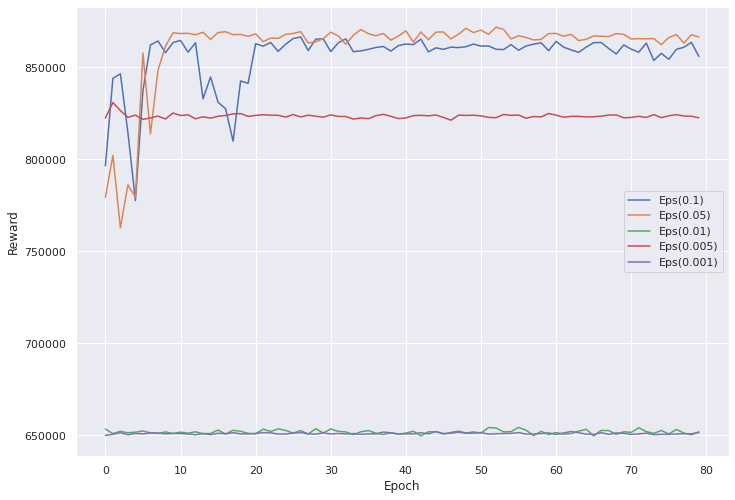

In [33]:
import matplotlib.pyplot as plt
num_iterations = 80
for epsilon in [0.1, 0.05, 0.01, 0.005, 0.001]:
  record_reward = [ ]
  agent=DQNAgent(state_size, action_size, epsilon)
  for it in range(num_iterations):
      reward, agent = train(agent)
      record_reward.append(reward)
      print(f'Iteration {it + 1}/{num_iterations}: rewards {round(np.mean(record_reward), 2)} +/- {round(np.std(record_reward), 2)}')
  plot_rewards(record_reward)
